In [2]:
import numpy as np
import pandas as pd
import cv2
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import psutil
from pympler import asizeof
import sklearn

# Load your CSV file
csv_file_path = '../DL_for_Hin_Chest_X_Ray/Data_Entry_2017_filtered_2.csv'
df = pd.read_csv(csv_file_path)

# Initialize constants
IMAGE_DIR = "../DL_for_Hin_Chest_X_Ray/HIN_archive/images/"

# Initialize the multi-label binarizer
mlb = MultiLabelBinarizer()

unique_labels = df["Finding Labels"].str.split("|").explode().unique()
mlb.fit([unique_labels])
labels_for_class = ['Atelectasis', 'Effusion', 'Infiltration', 'No Finding']

In [3]:
def preprocess_image(file_path, image_size):
    """
    Loads and preprocesses an image from the given file path.
    Resizes to the specified image size and normalizes pixel values.
    """
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
    if image is None:
        return None
    image = cv2.resize(image, (image_size, image_size))
    # image = image / 255.0  # Normalize pixel values to [0, 1]
    return image


def prepare_data(df, image_size, image_dir=IMAGE_DIR):
    """
    Prepares images and labels from the dataset for model training.
    - Loads images based on 'Image Index' in the dataframe.
    - Converts 'Finding Labels' to one-hot encoded vectors.
    - Returns arrays of images and labels.
    """
    images = []
    labels = []
    
    for _, row in tqdm(df.iterrows(), total=len(df)):
        # Construct image path
        image_path = os.path.join(image_dir, row["Image Index"])
        image = preprocess_image(image_path, image_size)
        
        if image is not None:
            images.append(image)
            # Convert labels into a list of diseases, then one-hot encode
            label = row["Finding Labels"].split("|")
            labels.append(label)
    
    # Convert lists to arrays
    images = np.array(images).reshape(-1, image_size, image_size, 1)  # Adding channel dimension for grayscale
    labels = mlb.transform(labels)  # Convert labels to multi-label one-hot encoding
    
    return images, labels


def create_model(image_size):
    model = Sequential([
        Input(shape=(image_size, image_size, 1)),
        Conv2D(32, (3, 3), activation='relu'),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(unique_labels), activation='softmax')
    ])

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

def evaluate(model, images_val, labels_val, num_classes):
    # Get the model's predictions (probabilities) for the validation set
    probabilities = model.predict(images_val)

    # Initialize an empty list to store the AUCs
    auc_per_class = {}

    # Calculate AUC for each class
    for class_idx in range(num_classes):
        true_labels = labels_val[:, class_idx]  # True labels for this class
        pred_probs = probabilities[:, class_idx]  # Predicted probabilities for this class

        # Calculate the AUC for this class
        auc = sklearn.metrics.roc_auc_score(true_labels, pred_probs)
        auc_per_class[labels_for_class[class_idx]] = auc        
        
    probabilities_transformed = probabilities.argmax(axis=1)
    labels_val_transformed = labels_val.argmax(axis=1)

    balanced_acc = sklearn.metrics.balanced_accuracy_score(labels_val_transformed, probabilities_transformed)
    acc = sklearn.metrics.accuracy_score(labels_val_transformed, probabilities_transformed)

    return auc_per_class, balanced_acc, acc


In [ ]:
# Test for memory consumption
image_si = 100

images, labels = prepare_data(df[:1], image_si, IMAGE_DIR)
images2, labels2 = prepare_data(df[:3], image_si, IMAGE_DIR)
image = cv2.imread(IMAGE_DIR + '/00000001_000.png', cv2.IMREAD_GRAYSCALE)
cv2.imwrite("xray_50.png", cv2.resize(image, (50, 50)))
cv2.imwrite("xray_400.png", cv2.resize(image, (400, 400)))
cv2.imwrite("xray_1024.png", image)

print(asizeof.asizeof(image))
print()


print(asizeof.asizeof(images))
print(images.nbytes)
print(asizeof.asizeof(images2))
print("per image: " + str(asizeof.asizeof(images2) - asizeof.asizeof(images)))


In [21]:
IMAGE_SIZE = 256
NUMBER_OF_IMAGES = 1000
BATCH_SIZE = 16

def normalize_image(img, label):
    img = tf.cast(img, np.float32) / 255.0
    return img, label

images, labels = prepare_data(df[:NUMBER_OF_IMAGES], IMAGE_SIZE)
images_test, labels_test = prepare_data(df[-(int(NUMBER_OF_IMAGES / 5)):], IMAGE_SIZE)

images_train, images_val, labels_train, labels_val = sklearn.model_selection.train_test_split(images, labels, random_state=42, test_size=0.2)
    
dataset = tf.data.Dataset.from_tensor_slices((images_train, labels_train))
dataset = dataset.map(normalize_image)
dataset = dataset.shuffle(buffer_size=100)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset = dataset.repeat()

val_dataset = tf.data.Dataset.from_tensor_slices((images_val, labels_val))
val_dataset = val_dataset.map(normalize_image)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=False)
    
model = create_model(IMAGE_SIZE)

class_weights = {}
num_classes = len(unique_labels)

for class_idx in range(num_classes):
    class_count = np.sum(labels[:, class_idx])
    class_weight = len(labels) / (num_classes * (class_count + 1e-5)) 
    class_weights[class_idx] = class_weight

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(dataset, epochs=20, batch_size=BATCH_SIZE, steps_per_epoch=len(images_train) // BATCH_SIZE, validation_data=val_dataset, validation_steps=len(images_val)//BATCH_SIZE, callbacks=[early_stopping], class_weight=class_weights, verbose=1)

evals = evaluate(model, images_test, labels_test, len(unique_labels))
print(evals)

100%|██████████| 200/200 [00:01<00:00, 108.71it/s]


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 363ms/step - accuracy: 0.3720 - loss: 13.4779 - val_accuracy: 0.2604 - val_loss: 1.3890
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 346ms/step - accuracy: 0.4601 - loss: 1.2988 - val_accuracy: 0.2708 - val_loss: 1.3734
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 347ms/step - accuracy: 0.5576 - loss: 1.1962 - val_accuracy: 0.2292 - val_loss: 1.4146
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 403ms/step - accuracy: 0.5520 - loss: 1.1690 - val_accuracy: 0.3802 - val_loss: 1.4521
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 336ms/step - accuracy: 0.7290 - loss: 0.8230 - val_accuracy: 0.4323 - val_loss: 1.6123
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 332ms/step - accuracy: 0.8045 - loss: 0.5330 - val_accuracy: 0.5417 - val_loss: 2.0361
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 330ms/step - accuracy: 0.8509 - loss: 0.4256 - val_accuracy: 0.4688 - val_loss: 1.8310
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
({'Atelectasis': 0.6732336956521738, 'Effusion': 0.3410138

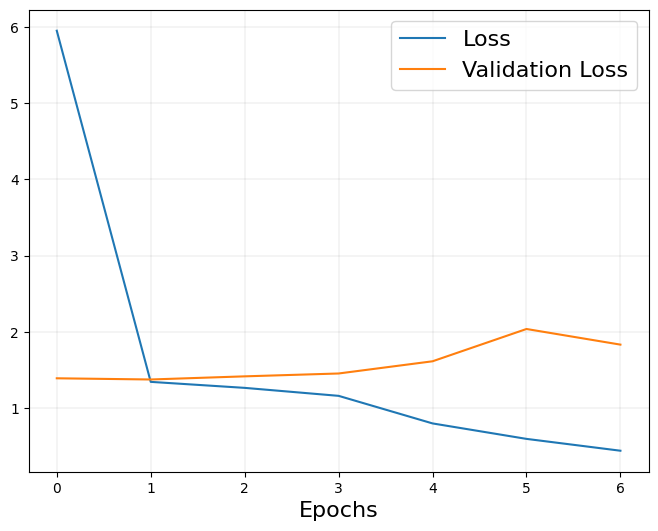

In [22]:
plt.figure(figsize=(8, 6))

font_size = 16

plt.plot(history.history['loss'], label="Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")

plt.xlabel("Epochs", fontsize=font_size)
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.legend(fontsize=font_size, loc="upper right")

plt.savefig("evals/history_256px_1000samples.pdf", bbox_inches='tight', pad_inches=0)

plt.show()


In [4]:
BATCH_SIZE = 16
NUMBER_OF_IMAGES = 10000
evaluations = {}

def normalize_image(img, label):
    img = tf.cast(img, np.float32) / 255.0
    return img, label


for ev_image_size in [50, 100, 150, 200, 250, 300, 350, 400]:
    
    images, labels = prepare_data(df[:NUMBER_OF_IMAGES], ev_image_size)
    images_test, labels_test = prepare_data(df[-(int(NUMBER_OF_IMAGES / 5)):], ev_image_size)

    images_train, images_val, labels_train, labels_val = sklearn.model_selection.train_test_split(images, labels, random_state=42, test_size=0.2)

    dataset = tf.data.Dataset.from_tensor_slices((images_train, labels_train))
    dataset = dataset.map(normalize_image)
    dataset = dataset.shuffle(buffer_size=100)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=False)
    dataset = dataset.repeat()
    
    val_dataset = tf.data.Dataset.from_tensor_slices((images_val, labels_val))
    val_dataset = val_dataset.map(normalize_image)
    val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=False)
        
    model = create_model(ev_image_size)
    
    class_weights = {}
    num_classes = len(unique_labels)
    
    for class_idx in range(num_classes):
        class_count = np.sum(labels[:, class_idx])
        class_weight = len(labels) / (num_classes * (class_count + 1e-5)) 
        class_weights[class_idx] = class_weight

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(dataset, epochs=20, batch_size=BATCH_SIZE, steps_per_epoch=len(images_train) // BATCH_SIZE, validation_data=val_dataset, validation_steps=len(images_val)//BATCH_SIZE, callbacks=[early_stopping], class_weight=class_weights, verbose=2)
    
    evals = evaluate(model, images_test, labels_test, len(unique_labels))
    
    evaluations[ev_image_size] = evals
    print()
    print(evals)
    print()
    
print(evaluations)

100%|██████████| 2000/2000 [00:18<00:00, 107.82it/s]
2025-02-22 15:04:05.285435: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-02-22 15:04:05.285470: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-02-22 15:04:05.285479: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-02-22 15:04:05.285499: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-22 15:04:05.285521: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/20


2025-02-22 15:04:06.217781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


500/500 - 15s - 31ms/step - accuracy: 0.2471 - loss: 1.4222 - val_accuracy: 0.1125 - val_loss: 1.3931
Epoch 2/20
500/500 - 14s - 28ms/step - accuracy: 0.2041 - loss: 1.3618 - val_accuracy: 0.2145 - val_loss: 1.3518
Epoch 3/20
500/500 - 14s - 28ms/step - accuracy: 0.2565 - loss: 1.3351 - val_accuracy: 0.3695 - val_loss: 1.2631
Epoch 4/20
500/500 - 14s - 28ms/step - accuracy: 0.3120 - loss: 1.3103 - val_accuracy: 0.3080 - val_loss: 1.3448
Epoch 5/20
500/500 - 14s - 28ms/step - accuracy: 0.3512 - loss: 1.2796 - val_accuracy: 0.4145 - val_loss: 1.2198
Epoch 6/20
500/500 - 14s - 28ms/step - accuracy: 0.3661 - loss: 1.2375 - val_accuracy: 0.4080 - val_loss: 1.2311
Epoch 7/20
500/500 - 14s - 28ms/step - accuracy: 0.3944 - loss: 1.2063 - val_accuracy: 0.3865 - val_loss: 1.2903
Epoch 8/20
500/500 - 14s - 28ms/step - accuracy: 0.4089 - loss: 1.1701 - val_accuracy: 0.4810 - val_loss: 1.1957
Epoch 9/20
500/500 - 14s - 28ms/step - accuracy: 0.4191 - loss: 1.1307 - val_accuracy: 0.4795 - val_loss: 1

100%|██████████| 2000/2000 [00:17<00:00, 117.43it/s]


Epoch 1/20
500/500 - 21s - 42ms/step - accuracy: 0.1284 - loss: 1.5342 - val_accuracy: 0.1270 - val_loss: 1.4002
Epoch 2/20
500/500 - 20s - 40ms/step - accuracy: 0.2274 - loss: 1.3834 - val_accuracy: 0.1235 - val_loss: 1.4123
Epoch 3/20
500/500 - 20s - 40ms/step - accuracy: 0.2479 - loss: 1.3750 - val_accuracy: 0.1640 - val_loss: 1.4042
Epoch 4/20
500/500 - 20s - 40ms/step - accuracy: 0.2600 - loss: 1.3431 - val_accuracy: 0.1440 - val_loss: 1.4510
Epoch 5/20
500/500 - 20s - 40ms/step - accuracy: 0.3067 - loss: 1.3339 - val_accuracy: 0.2405 - val_loss: 1.3918
Epoch 6/20
500/500 - 20s - 40ms/step - accuracy: 0.3359 - loss: 1.2498 - val_accuracy: 0.4155 - val_loss: 1.2634
Epoch 7/20
500/500 - 20s - 39ms/step - accuracy: 0.3749 - loss: 1.1911 - val_accuracy: 0.2625 - val_loss: 1.4379
Epoch 8/20
500/500 - 20s - 40ms/step - accuracy: 0.4021 - loss: 1.1410 - val_accuracy: 0.4300 - val_loss: 1.2853
Epoch 9/20
500/500 - 20s - 40ms/step - accuracy: 0.4380 - loss: 1.0693 - val_accuracy: 0.4375 - 

100%|██████████| 2000/2000 [00:17<00:00, 117.28it/s]


Epoch 1/20
500/500 - 38s - 76ms/step - accuracy: 0.1887 - loss: 1.5428 - val_accuracy: 0.1450 - val_loss: 1.3945
Epoch 2/20
500/500 - 37s - 74ms/step - accuracy: 0.2545 - loss: 1.3762 - val_accuracy: 0.1555 - val_loss: 1.4041
Epoch 3/20
500/500 - 37s - 74ms/step - accuracy: 0.2459 - loss: 1.3592 - val_accuracy: 0.1665 - val_loss: 1.3963
Epoch 4/20
500/500 - 37s - 74ms/step - accuracy: 0.2911 - loss: 1.2933 - val_accuracy: 0.1605 - val_loss: 1.4426
Epoch 5/20
500/500 - 37s - 74ms/step - accuracy: 0.3374 - loss: 1.1989 - val_accuracy: 0.3260 - val_loss: 1.3469
Epoch 6/20
500/500 - 37s - 75ms/step - accuracy: 0.4009 - loss: 1.0722 - val_accuracy: 0.3260 - val_loss: 1.3626
Epoch 7/20
500/500 - 37s - 74ms/step - accuracy: 0.4678 - loss: 0.9829 - val_accuracy: 0.3045 - val_loss: 1.5290
Epoch 8/20
500/500 - 38s - 76ms/step - accuracy: 0.5142 - loss: 0.9136 - val_accuracy: 0.3530 - val_loss: 1.5243
Epoch 9/20
500/500 - 37s - 75ms/step - accuracy: 0.5450 - loss: 0.8385 - val_accuracy: 0.4605 - 

100%|██████████| 2000/2000 [00:17<00:00, 113.87it/s]


Epoch 1/20
500/500 - 64s - 127ms/step - accuracy: 0.2150 - loss: 1.8973 - val_accuracy: 0.1325 - val_loss: 1.3853
Epoch 2/20
500/500 - 62s - 123ms/step - accuracy: 0.2590 - loss: 1.3748 - val_accuracy: 0.1340 - val_loss: 1.3933
Epoch 3/20
500/500 - 71s - 142ms/step - accuracy: 0.2159 - loss: 1.3811 - val_accuracy: 0.1305 - val_loss: 1.4285
Epoch 4/20
500/500 - 106s - 211ms/step - accuracy: 0.2641 - loss: 1.3147 - val_accuracy: 0.2200 - val_loss: 1.3818
Epoch 5/20
500/500 - 59s - 119ms/step - accuracy: 0.3300 - loss: 1.1777 - val_accuracy: 0.2880 - val_loss: 1.3636
Epoch 6/20
500/500 - 59s - 117ms/step - accuracy: 0.4105 - loss: 1.0569 - val_accuracy: 0.2690 - val_loss: 1.4271
Epoch 7/20
500/500 - 60s - 119ms/step - accuracy: 0.4710 - loss: 0.9736 - val_accuracy: 0.2785 - val_loss: 1.5002
Epoch 8/20
500/500 - 59s - 119ms/step - accuracy: 0.5344 - loss: 0.8384 - val_accuracy: 0.3265 - val_loss: 1.6106
Epoch 9/20
500/500 - 60s - 119ms/step - accuracy: 0.5875 - loss: 0.7971 - val_accuracy:

100%|██████████| 2000/2000 [00:17<00:00, 116.60it/s]


Epoch 1/20
500/500 - 117s - 234ms/step - accuracy: 0.2506 - loss: 2.6978 - val_accuracy: 0.0950 - val_loss: 1.4039
Epoch 2/20
500/500 - 114s - 228ms/step - accuracy: 0.2779 - loss: 1.3667 - val_accuracy: 0.2045 - val_loss: 1.3848
Epoch 3/20
500/500 - 113s - 226ms/step - accuracy: 0.3178 - loss: 1.3038 - val_accuracy: 0.2150 - val_loss: 1.4170
Epoch 4/20
500/500 - 113s - 226ms/step - accuracy: 0.3856 - loss: 1.1528 - val_accuracy: 0.3065 - val_loss: 1.3908
Epoch 5/20
500/500 - 113s - 226ms/step - accuracy: 0.4879 - loss: 0.9789 - val_accuracy: 0.3280 - val_loss: 1.4144
Epoch 6/20
500/500 - 113s - 225ms/step - accuracy: 0.5445 - loss: 0.8930 - val_accuracy: 0.4175 - val_loss: 1.3486
Epoch 7/20
500/500 - 113s - 226ms/step - accuracy: 0.5679 - loss: 0.9314 - val_accuracy: 0.3980 - val_loss: 1.4059
Epoch 8/20
500/500 - 113s - 227ms/step - accuracy: 0.6241 - loss: 0.8010 - val_accuracy: 0.4080 - val_loss: 1.4930
Epoch 9/20
500/500 - 113s - 226ms/step - accuracy: 0.6605 - loss: 0.7487 - val_a

100%|██████████| 2000/2000 [00:17<00:00, 112.25it/s]


Epoch 1/20
500/500 - 228s - 457ms/step - accuracy: 0.2655 - loss: 1.8116 - val_accuracy: 0.2010 - val_loss: 1.3776
Epoch 2/20
500/500 - 228s - 456ms/step - accuracy: 0.3274 - loss: 1.3634 - val_accuracy: 0.2195 - val_loss: 1.3784
Epoch 3/20
500/500 - 225s - 450ms/step - accuracy: 0.3537 - loss: 1.2885 - val_accuracy: 0.2455 - val_loss: 1.3965
Epoch 4/20
500/500 - 227s - 453ms/step - accuracy: 0.4153 - loss: 1.1143 - val_accuracy: 0.2880 - val_loss: 1.4175
Epoch 5/20
500/500 - 224s - 448ms/step - accuracy: 0.4920 - loss: 0.9714 - val_accuracy: 0.3695 - val_loss: 1.4094
Epoch 6/20
500/500 - 224s - 448ms/step - accuracy: 0.5721 - loss: 0.8160 - val_accuracy: 0.4275 - val_loss: 1.4699
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step

({'Atelectasis': 0.5523461760249858, 'Effusion': 0.4798076058895903, 'Infiltration': 0.5195587205103188, 'No Finding': 0.49805198258722516}, 0.2641655059347608, 0.538)


100%|██████████| 2000/2000 [00:17<00:00, 115.17it/s]


Epoch 1/20
500/500 - 313s - 627ms/step - accuracy: 0.1844 - loss: 3.5559 - val_accuracy: 0.1175 - val_loss: 1.4000
Epoch 2/20
500/500 - 305s - 610ms/step - accuracy: 0.2340 - loss: 1.3816 - val_accuracy: 0.2295 - val_loss: 1.3881
Epoch 3/20
500/500 - 383s - 766ms/step - accuracy: 0.3079 - loss: 1.3614 - val_accuracy: 0.2410 - val_loss: 1.3942
Epoch 4/20
500/500 - 426s - 852ms/step - accuracy: 0.3134 - loss: 1.2986 - val_accuracy: 0.3015 - val_loss: 1.3598
Epoch 5/20
500/500 - 427s - 854ms/step - accuracy: 0.3694 - loss: 1.1298 - val_accuracy: 0.3040 - val_loss: 1.4268
Epoch 6/20
500/500 - 450s - 900ms/step - accuracy: 0.4827 - loss: 0.9182 - val_accuracy: 0.2845 - val_loss: 1.4935
Epoch 7/20
500/500 - 466s - 932ms/step - accuracy: 0.5545 - loss: 0.8750 - val_accuracy: 0.3620 - val_loss: 1.4640
Epoch 8/20
500/500 - 336s - 673ms/step - accuracy: 0.5945 - loss: 0.7516 - val_accuracy: 0.4525 - val_loss: 1.5176
Epoch 9/20
500/500 - 357s - 713ms/step - accuracy: 0.6685 - loss: 0.6396 - val_a

100%|██████████| 2000/2000 [00:18<00:00, 108.76it/s]


Epoch 1/20
500/500 - 525s - 1s/step - accuracy: 0.2549 - loss: 3.7659 - val_accuracy: 0.1400 - val_loss: 1.4026
Epoch 2/20
500/500 - 440s - 880ms/step - accuracy: 0.2797 - loss: 1.3865 - val_accuracy: 0.1430 - val_loss: 1.4452
Epoch 3/20
500/500 - 454s - 907ms/step - accuracy: 0.3031 - loss: 1.3327 - val_accuracy: 0.1920 - val_loss: 1.4613
Epoch 4/20
500/500 - 454s - 908ms/step - accuracy: 0.3871 - loss: 1.1740 - val_accuracy: 0.2435 - val_loss: 1.4951
Epoch 5/20
500/500 - 466s - 933ms/step - accuracy: 0.4843 - loss: 0.9436 - val_accuracy: 0.3155 - val_loss: 1.4721
Epoch 6/20
500/500 - 493s - 986ms/step - accuracy: 0.5475 - loss: 0.9969 - val_accuracy: 0.3335 - val_loss: 1.5070
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step

({'Atelectasis': 0.5248998026497229, 'Effusion': 0.45560028635979055, 'Infiltration': 0.4888014785342816, 'No Finding': 0.4759776580564637}, 0.2711734688886399, 0.6465)

{50: ({'Atelectasis': 0.5786804393998546, 'Effusion': 0.5491956203067521, 'Infiltration': 0.50603777

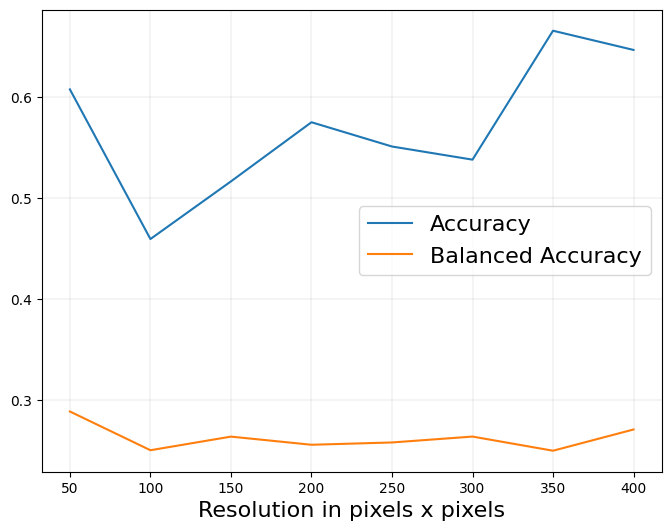

In [8]:
plt.figure(figsize=(8, 6))

with open("pickles/resolution_10000samples_nolr.pkl", "wb") as file:
    pickle.dump(evaluations, file)

aucs = [evalu[0] for evalu in evaluations.values()]
aucs_at = [evalu["Atelectasis"] for evalu in aucs]
aucs_ef = [evalu["Effusion"] for evalu in aucs]
aucs_in = [evalu["Infiltration"] for evalu in aucs]
aucs_nf = [evalu["No Finding"] for evalu in aucs]
baccs = [evalu[1] for evalu in evaluations.values()]
accs = [evalu[2] for evalu in evaluations.values()]

x_values = [50, 100, 150, 200, 250, 300, 350, 400]

font_size = 16

plt.plot(x_values, accs, label="Accuracy")
plt.plot(x_values, baccs, label="Balanced Accuracy")

# plt.plot(x_values, aucs_at, label="Atelectasis")
# plt.plot(x_values, aucs_ef, label="Effusion")
# plt.plot(x_values, aucs_in, label="Infiltration")
# plt.plot(x_values, aucs_nf, label="No Finding")

plt.xlabel("Resolution in pixels x pixels", fontsize=font_size)
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.legend(fontsize=font_size, loc="center right")

plt.savefig("evals/resolution_accBacc_10000samples_nolr.pdf", bbox_inches='tight', pad_inches=0)

plt.show()

In [17]:
# Baseline

images, labels = prepare_data(df[:10000], 1)

# Calculate class probabilities
class_counts = np.sum(labels, axis=0)
class_probabilities = class_counts / len(labels)

# Prepare the test data
images_test, labels_test = prepare_data(df[-2000:], 1)

# Generate predictions based on class probabilities
predictions = []
for _ in range(len(labels_test)):
    predicted_class = np.random.choice(len(class_probabilities), p=class_probabilities)
    predictions.append(predicted_class)
    
predictions_proba = np.zeros((len(labels_test), len(class_probabilities)))
for i, predicted_class in enumerate(predictions):
    predictions_proba[i, predicted_class] = 1
    
evals = []
for class_idx in range(4):
    true_labels = labels_test[:, class_idx]  # True labels for this class
    pred_probs = predictions_proba[:, class_idx]  # Predicted probabilities for this class

    # Calculate the AUC for this class
    auc = sklearn.metrics.roc_auc_score(true_labels, pred_probs)
    evals.append(auc)
    print(f"AUC for class {class_idx}: {auc}")
    
    
probabilities_transformed = predictions
labels_val_transformed = labels_test.argmax(axis=1)

balanced_acc = sklearn.metrics.balanced_accuracy_score(labels_val_transformed, probabilities_transformed)
acc = sklearn.metrics.accuracy_score(labels_val_transformed, probabilities_transformed)

print(balanced_acc)
print(acc)

100%|██████████| 2000/2000 [00:17<00:00, 113.78it/s]

AUC for class 0: 0.508366792144671
AUC for class 1: 0.5067994954613213
AUC for class 2: 0.5111949011565078
AUC for class 3: 0.49801124565614185


0.2437245139110723
0.4665


In [ ]:
tf.keras.utils.plot_model(create_model(256), show_shapes=False, rankdir="LR")

In [ ]:
# Train for balanced accuracy
class_weights = {}
num_classes = len(unique_labels)

for class_idx in range(num_classes):
    class_count = np.sum(labels[:, class_idx])
    class_weight = len(labels) / (num_classes * (class_count + 1e-5)) 
    class_weights[class_idx] = class_weight


model.fit(dataset, epochs=10, batch_size=BATCH_SIZE, steps_per_epoch=len(images) // BATCH_SIZE, class_weight=class_weights, validation_data=(images_val, labels_val))
probabilities = model.predict(images_test)
predictions = probabilities.argmax(axis=1)
labels_test = labels_test.argmax(axis=1)

balanced_acc = sklearn.metrics.balanced_accuracy_score(labels_test, predictions)

balanced_acc